### Programming Exercise 2: Logistic Regression

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1 Logistic Regression

In [14]:
!ls ../../2_logistic_regression/logistic_reg_new/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
data = np.loadtxt('../../2_logistic_regression/logistic_reg_new/data1.txt', delimiter=',')
X = data[:, 0:2]
X = np.insert(X, 0, 1, axis=1)
y = data[:, -1]
m = y.shape[0]

#### 1.1 Visualizing the data

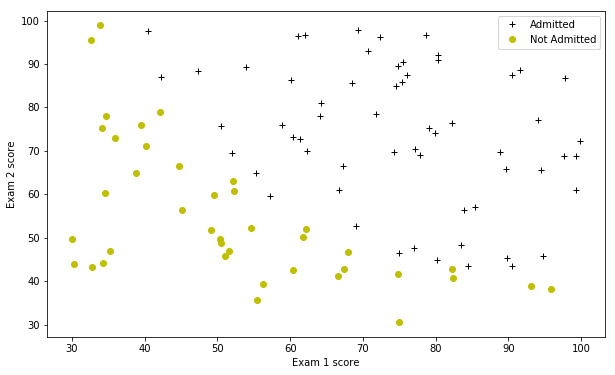

In [16]:
pos = np.where(y==1)
neg = np.where(y==0)
def plotData():
    plt.figure(figsize=(10, 6))
    plt.plot(X[pos][:, 1], X[pos][:, 2], 'k+', label='Admitted')
    plt.plot(X[neg][:, 1], X[neg][:, 2], 'yo', label='Not Admitted')
    # plt.grid(True)
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
plotData()

#### 1.2 Implementation

In [17]:
from scipy.special import expit  # sigmoid function

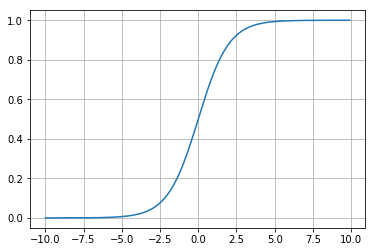

In [18]:
myx = np.arange(-10, 10, .1)
plt.plot(myx, expit(myx))
plt.grid(True)

In [19]:
# Hypothesis function
def h(mytheta, myX):
    return expit(np.dot(myX, mytheta))

# Cost function
def computeCost(mytheta, myX, myy, mylambda = 0.):
    term1 = np.dot(-np.array(myy).T, np.log(h(mytheta, myX)))  # y=1
    term2 = np.dot((1-np.array(myy)).T, np.log(1-h(mytheta, myX)))  # y=0
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T, mytheta[1:]))
    return float((1./m)*(np.sum(term1-term2)+regterm))

In [20]:
initial_theta = np.zeros((X.shape[1], 1))
computeCost(initial_theta, X, y)

0.6931471805599453

In [21]:
from scipy import optimize
def optimizeTheta(mytheta, myX, myy, mylambda=0.):
    result = optimize.fmin(computeCost, x0=mytheta, args=(myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]

In [22]:
theta, mincost = optimizeTheta(initial_theta, X, y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [23]:
print(computeCost(theta, X, y))

0.2034977015902151


In [24]:
theta

array([-25.16130062,   0.20623142,   0.20147143])

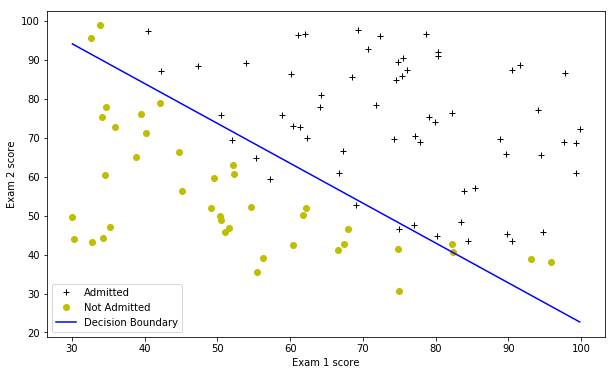

In [25]:
boundary_xs = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
boundary_ys = (-1/theta[2])*(theta[0]+theta[1]*boundary_xs)
plotData()
plt.plot(boundary_xs, boundary_ys, 'b-', label='Decision Boundary')
plt.legend()

In [26]:
print(h(theta, np.array([1, 45., 85.])))

0.7762915904112411


In [27]:
def makePrediction(mytheta, myx):
    return h(mytheta, myx) >= 0.5

pos_correct = float(np.sum(makePrediction(theta, X[pos])))
neg_correct = float(np.sum(np.invert(makePrediction(theta, X[neg]))))
tot = X[pos].shape[0]+X[neg].shape[0]
prcnt_correct = float(pos_correct+neg_correct)/tot
print('training set correctly predicted %f' % prcnt_correct)

training set correctly predicted 0.890000


### 2 Regularized Logistic Regerssion

#### 2.1 Visualizing the data

In [28]:
cols = np.loadtxt('../../2_logistic_regression/logistic_reg_new/data2.txt', delimiter=',', usecols=(0, 1, 2), unpack=True)
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X, 0, 1, axis=1) 
pos = np.array([X[i] for i in range(X.shape[0]) if y[i]==1])  # np[np.where(y==1)]
neg = np.array([X[i] for i in range(X.shape[0]) if y[i]==0])

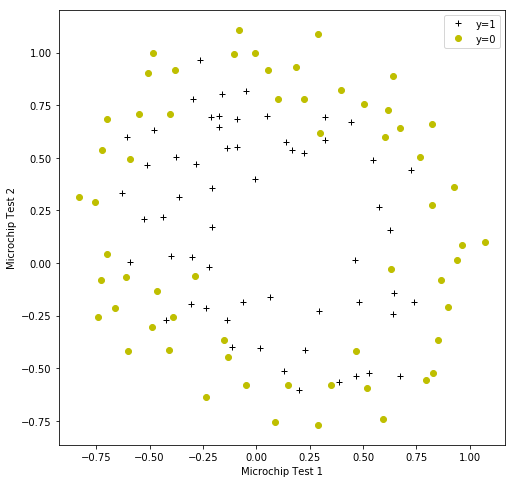

In [29]:
def plotData():
    plt.plot(pos[:, 1], pos[:, 2], 'k+', label='y=1')
    plt.plot(neg[:, 1], neg[:, 2], 'yo', label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
#     plt.grid(True)

plt.figure(figsize=(8, 8))
plotData()

#### 2.2 Feature mapping

In [30]:
def mapFeature(degrees,x1col, x2col):
#     degrees = 2
    out = np.ones((x1col.shape[0], 1))
    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term = (term1*term2).reshape(term1.shape[0], 1)
            out = np.hstack((out, term))
    return out

In [31]:
mappedX = mapFeature(6, X[:, 1], X[:, 2])
mappedX.shape

(118, 28)

In [32]:
initial_theta = np.zeros((mappedX.shape[1], 1))
computeCost(initial_theta, mappedX, y)

0.6931471805599454

In [33]:
def optimizeRegularizedTheata(mytheta, myX, myy, mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda), method='BFGS', options={'maxiter':500,'disp':False})
    return np.array([result.x]), result.fun
theta, mincost = optimizeRegularizedTheata(initial_theta, mappedX, y)
mincost

0.24835799276696516

#### 2.4 Plotting the decision boundary

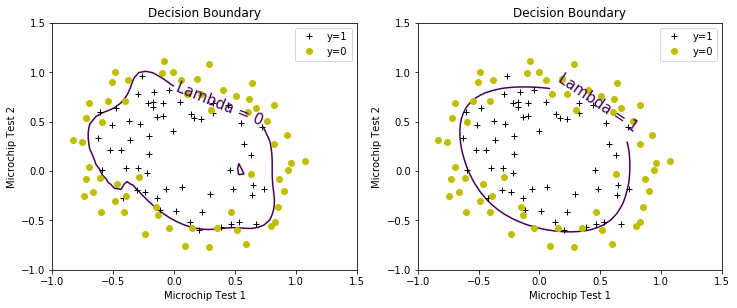

In [34]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    theta, mincost = optimizeRegularizedTheata(mytheta, myX, myy, mylambda)
    xvals = np.linspace(-1, 1.5, 50)
    yvals = np.linspace(-1, 1.5, 50)
    zvals = np.zeros((len(xvals), len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(6, np.array([xvals[i]]), np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta, myfeaturesij.T)
    zvals = zvals.T
    u, v= np.meshgrid(xvals, yvals)
    mycontour = plt.contour(xvals, yvals, zvals, [0])
    myfmt = {0:'Lambda = %d' % mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")
plt.figure(figsize=(12, 10))
plt.subplot(221)
plotData()
plotBoundary(theta, mappedX, y, 0.)

plt.subplot(222)
plotData()
plotBoundary(theta, mappedX, y, 1.)

### 3. Logistic Regression with sklearn

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

data = np.loadtxt('../../2_logistic_regression/logistic_reg_new/data1.txt', delimiter=',')
X = data[:, :-1]
y = data[:, -1]

# 这里需要打乱顺序，因为数据集的标签是有序的
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
# 统一化特征
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
model = LogisticRegression()
model.fit(X_train, y_train)
# 进行预测
y_pred = model.predict(X_test)
print('预测准确率为：%f' % np.mean(np.float64(y_pred==y_test) * 100))

预测准确率为：95.000000


### 4. Logistic Regression with OneVsAll-handwriten digits

In [36]:
def display_data(imgData):
    sum = 0
    pad = 1  # 分割线
    display_array = -np.ones((pad + 10 * (20 + pad), pad + 10 * (20 + pad)))  # (211, 211)
    """
        下面的二维循环可能不是很容易理解:
        其实很简单，就是将前面得到的像素内容填充到我们刚刚定义的display_array中
        然后通过plt显示出来
    """
    for i in range(10):
        for j in range(10):
            display_array[pad + i * (20 + pad):pad + i * (20 + pad) + 20,
            pad + j * (20 + pad):pad + j * (20 + pad) + 20] \
                = (imgData[sum, :].reshape(20, 20, order="F"))
            sum += 1
    plt.imshow(display_array, cmap='gray')
    # plt.axis('off')
    # plt.figure(figsize=(12, 12))
    plt.show()

In [44]:
def oneVsAll(X, y, num_labels, Lambda):
    m, n = X.shape
    all_theta = np.zeros((n+1, num_labels))  # 补上theta0
    X = np.insert(X, 0, 1, axis=1)
    class_y = np.zeros((m, num_labels))
    initial_theta = np.zeros((n+1, 1))
    for i in range(num_labels):
        class_y[:, i] = np.int32(y==i).reshape(1, -1)  # 0 -> 1000000000
    # 计算theta
    for i in range(num_labels):
        result = optimize.fmin_bfgs(computeCost, initial_theta, fprime=gradient, args=(X, class_y[:, i], Lambda))
        all_theta[:, i] = result.reshape(1, -1)
    all_theta = all_theta.T
    return all_theta

In [38]:
def gradient(initial_theta, X, y, initial_Lambda):
    m = len(y)
    h = sigmoid(np.dot(X, initial_theta.T))
    theta1 = initial_theta.copy()
    theta1[0] = 0
    grad = np.zeros((initial_theta.shape[0]))
    grad = np.dot(np.transpose(X), h-y)/m + initial_theta/m * theta1
    return grad

In [39]:
def predict_oneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros((m, 1))
    X = np.insert(X, 0, 1, axis=1)#  X = np.hstack((np.ones((m, 1)), X))
    h = sigmoid(np.dot(X, all_theta.T))
    
    p = np.array(np.where(h[0, :]==np.max(h, axis=1)[0]))
    for i in range(1, m):
        t = np.array(np.where(h[i, :]==np.max(h, axis=1)[i]))
        p = np.vstack((p, t))
    return p

In [40]:
def sigmoid(z):
    h = np.zeros((len(z), 1))
    h = 1.0/(1.0+np.exp(-z))
    return h

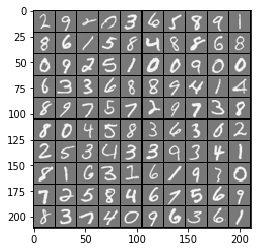

         Current function value: 0.031057
         Iterations: 31
         Function evaluations: 88
         Gradient evaluations: 77
         Current function value: 0.029596
         Iterations: 40
         Function evaluations: 134
         Gradient evaluations: 122
         Current function value: 0.072616
         Iterations: 40
         Function evaluations: 84
         Gradient evaluations: 72
         Current function value: 0.072550
         Iterations: 48
         Function evaluations: 155
         Gradient evaluations: 143
         Current function value: 0.056473
         Iterations: 35
         Function evaluations: 122
         Gradient evaluations: 110
         Current function value: 0.081564
         Iterations: 45
         Function evaluations: 141
         Gradient evaluations: 129
         Current function value: 0.037277
         Iterations: 41
         Function evaluations: 141
         Gradient evaluations: 129
         Current function value: 0.047950
         I

In [45]:
import scipy.io as spio
# 利用scipy的io读mat文件
data = spio.loadmat('../../2_logistic_regression/logistic_reg_new/data_digits.mat')
X = data['X']
y = data['y']
m, n = X.shape  # (5000, 400): feature: 20px*20px; training set: 5000
num_labels = 10  # 0, 1, 2, 3,...9
# 随机显示100个数字图片
rand_indices = [np.random.randint(0, m) for x in range(100)]
# X[rand_indices, :]  得到随机的100行
display_data(X[rand_indices, :])
Lambda = 0.1 
all_theta = oneVsAll(X, y, num_labels, Lambda)
p = predict_oneVsAll(all_theta, X)
print('预测准确率为：%f%%' % np.mean(np.float64(p == y.reshape(-1, 1))*100))

### 5. OneVsAll with sklearn

In [47]:
X = data['X']
y = data['y']
y = np.ravel(y)
model = LogisticRegression()
model.fit(X, y)
p = model.predict(X)
print('预测准确率为：%f%%' % np.mean(np.float64(p==y) * 100))

预测准确率为：94.380000%
